The code function is calculating the TTC with trajectory;
计算TTC指标，这里选择最为基本的TTC计算方法，带有角度的TTC计算。
整个代码采取分布式结构，分为主程序、功能函数
计算TTC时按照时间帧进行更新，逐帧逐车计算所有车辆之间TTC选择最小作为其TTC值（只考虑一种计算方法）

Change the windows of the jupyter notebook

In [4]:
# install jupyterthemes
!pip install jupyterthemes
# upgrade to latest version
!pip install --upgrade jupyterthemes

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [5]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [9]:
!jt -t grade3 -tf merriserif -tfs 16 -nf ptsans -nfs 16 -fs 14 -cellw 98%

import the based pageackage

In [2]:
import math
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import the data

In [96]:
Data_path = r'E:\CodeResource\Trajectorymodeling\Trajectory\trajectory_data\trajectory_c0008.csv'
Original_data = pd.read_csv(Data_path)
veh_type = pd.unique(Original_data['vehicle_type'])
# delet the trajectory point out of the intersection 
Original_data = Original_data.drop(Original_data[Original_data.world_x <= -10].index)
Original_data = Original_data.drop(Original_data[Original_data.world_x >= 45].index)
Original_data = Original_data.drop(Original_data[Original_data.world_y <= -10].index)
Original_data = Original_data.drop(Original_data[Original_data.world_y >= 50].index)
# delete the pedestrian trajectory
Original_data = Original_data.drop(Original_data[Original_data.vehicle_type ==' Pedestrian'].index)
Trajectory_new = Original_data.copy()
Trajectory_new.to_csv('E:/CodeResource/Trajectorymodeling/Trajectory/conflict_indector/trajectory_data/trajectory_new.csv')

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pywt 

#封装成函数
def sgn(num):
    if(num > 0.0):
        return 1.0
    elif(num == 0.0):
        return 0.0
    else:
        return -1.0

def wavelet_noising(new_df):
    data = new_df
    data = data.values.T.tolist()  # 将np.ndarray()转为列表
    w = pywt.Wavelet('sym8')#选择sym8小波基
    [ca5, cd5, cd4, cd3, cd2, cd1] = pywt.wavedec(data, w, level=5)  # 5层小波分解

    length1 = len(cd1)
    length0 = len(data)

    Cd1 = np.array(cd1)
    abs_cd1 = np.abs(Cd1)
    median_cd1 = np.median(abs_cd1)
    sigma = (1.0 / 0.6745) * median_cd1
    lamda = sigma * math.sqrt(2.0 * math.log(float(length0 ), math.e))#固定阈值计算
    usecoeffs = []
    usecoeffs.append(ca5)  # 向列表末尾添加对象
    #软硬阈值折中的方法
    a = 0.5
    for k in range(length1):
        if (abs(cd1[k]) >= lamda):
            cd1[k] = sgn(cd1[k]) * (abs(cd1[k]) - a * lamda)
        else:
            cd1[k] = 0.0
    length2 = len(cd2)
    for k in range(length2):
        if (abs(cd2[k]) >= lamda):
            cd2[k] = sgn(cd2[k]) * (abs(cd2[k]) - a * lamda)
        else:
            cd2[k] = 0.0
    length3 = len(cd3)
    for k in range(length3):
        if (abs(cd3[k]) >= lamda):
            cd3[k] = sgn(cd3[k]) * (abs(cd3[k]) - a * lamda)
        else:
            cd3[k] = 0.0
    length4 = len(cd4)
    for k in range(length4):
        if (abs(cd4[k]) >= lamda):
            cd4[k] = sgn(cd4[k]) * (abs(cd4[k]) - a * lamda)
        else:
            cd4[k] = 0.0
    length5 = len(cd5)
    for k in range(length5):
        if (abs(cd5[k]) >= lamda):
            cd5[k] = sgn(cd5[k]) * (abs(cd5[k]) - a * lamda)
        else:
            cd5[k] = 0.0
    usecoeffs.append(cd5)
    usecoeffs.append(cd4)
    usecoeffs.append(cd3)
    usecoeffs.append(cd2)
    usecoeffs.append(cd1)
    recoeffs = pywt.waverec(usecoeffs, w)#信号重构
    return recoeffs

define the function of motion state  

In [67]:
# Original_data

In [99]:
def Trajmap(Data):
    # 设置图框大小
#     plt.Figure([2000,2000],dpi=20)
    fig = plt.figure(figsize=(14,7))   
#     sns.despine(left=True)    
    #绘制轨迹
    plt.scatter(Data['world_x'],Data['world_y'],c='red',label='Ground trajectory',s=1)
    plt.legend()
    plt.legend(loc="upper right",fontsize=12)   #设置图例字体大小
    plt.xlabel('X (m))',fontsize=16)     #设置x轴名称
    plt.legend(loc="upper right",fontsize=16)   #设置图例字体大小
    # 坐标尺
    plt.xticks(fontsize=12,rotation=0)
    plt.yticks(fontsize=12)
    # 坐标名称
    plt.rcParams.update({"font.size":16})
    plt.ylabel('Y (m)',fontsize=16)     #设置y轴名称  
    plt.grid()
    plt.show() 
    
# 多维轨迹显示图
# 绘制时空分布图
# the map of trajectory with three Dimension（world_x,world_y,speed）
def Stmap(data):
    # 计算车辆个数
    vehids = pd.unique(data["vehicle_id"])
    # 设置图框大小
    plt.Figure([2200,2200],dpi=1000)
    for vehid in vehids:
        # 获取第vehid辆车的轨迹
        traj_vehid = data[data.vehicle_id == vehid]
        # 获取x方向轨迹点
        x = traj_vehid['world_x']
        y = traj_vehid['world_y']
        v = traj_vehid['veh_speed']
        norm = matplotlib.colors.Normalize(vmin=0, vmax=50)
        # 绘制散点图
        ax = plt.scatter(x,y, marker = '.', s=0.01, c=v, cmap='jet_r', norm = norm)
    plt.clim(0, 25)
    plt.colorbar()
    plt.grid()
    plt.show()

Read the trajectory data

In [105]:
data_path_traj = r'E:/CodeResource/Trajectorymodeling/Trajectory/conflict_indector/trajectory_data/trajectory_new.csv'
traj_data = pd.read_csv(data_path_traj)
# map_trajectory = Trajmap(traj_data)
# Delete the abnormal trajectory, the time less than 2secondes and over than 5mint
veh_id_tt = pd.unique(traj_data['vehicle_id'])
for vehidd in veh_id_tt:
    traj_vehid = traj_data[traj_data['vehicle_id']==vehidd]
    if len(traj_vehid)<125:
        print('this vehicle'+str(vehidd) +'less than 5 second,is abnormal,should remove from the trajectory dataset.')
        traj_data = traj_data.drop(traj_data[traj_data.vehicle_id == vehidd].index)
    elif len(traj_vehid)>5000:
        print('this vehicle'+str(vehidd) +' more than 3.5min. is abnormal,should remove from the trajectory dataset.')
        traj_data = traj_data.drop(traj_data[traj_data.vehicle_id == vehidd].index)
# map_trajectory = Trajmap(traj_data)
Map_trajectory = pd.DataFrame(traj_data)
Map_trajectory.to_csv('E:/CodeResource/Trajectorymodeling/Trajectory/conflict_indector/clearn_data/clearn_c0008.csv')

this vehicle6less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle9less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle10less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle12less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle13less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle14less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle20less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle28less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle32less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle34less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle45less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle51less than 5 second,i

this vehicle795less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle812less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle847less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle853less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle900less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle901less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle903less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle907less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle908less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle922less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle924less than 5 second,is abnormal,should remove from the trajectory dataset.
this vehicle954less t

In [ ]:
# shown the map of trajectory
Fig = Stmap(Map_trajectory)

Calculate the motion of the vehilce 

In [2]:
# 计算轨迹中的速度/加速度/加加速度
def XY(groundtraj,caompartraj):
    g_World_x = np.array(groundtraj['world_x'].astype(float))
    g_World_y = np.array(groundtraj['world_y'].astype(float))
    com_World_x = np.array(caompartraj['world_x'].astype(float))
    com_World_y = np.array(caompartraj['world_y'].astype(float))    
    return g_World_x,g_World_y,com_World_x,com_World_y

def Velocity(trajdata):
    """recalculate the velocity, the velocity contain the X_velocity and Y-velocity and the speed"""
    """定义初速度为0"""
    len_x = trajdata.shape[0]
    wordld_x = np.array(trajdata.world_x)
    wordld_y = np.array(trajdata.world_y)
    velocity_x = (wordld_x[1:len_x]-wordld_x[0:len_x-1])/0.04
    velocity_y = (wordld_y[1:len_x]-wordld_y[0:len_x-1])/0.04
    velocity_x = np.insert(velocity_x,0,0)
    velocity_y = np.insert(velocity_y,0,0)
    return velocity_x,velocity_y

def Accelection(trajdata):
    """定结束时刻的加速度为0"""
#     print(trajdata)
    len_x = trajdata.shape[0]
    velocity_x = np.array(trajdata.speed_x)
    velocity_y = np.array(trajdata.speed_y)
    accelection_x = (velocity_x[1:len_x]-velocity_x[0:len_x-1])/0.04
    accelection_y = (velocity_y[1:len_x]-velocity_y[0:len_x-1])/0.04
    accelection_x = np.insert(accelection_x,0,0)
    accelection_y = np.insert(accelection_y,0,0)
#     print(accelection_x)
    accelection_x[1] = 0
    accelection_y[1] = 0
    return accelection_x,accelection_y

def Aclculate_Jerk(trajdata):
    """计算急动度""" 
    len_x = trajdata.acc_x.shape[0]
    acc_x = np.array(trajdata.acc_x)
    acc_y = np.array(trajdata.acc_y)
    JJerk_x = (acc_x[1:len_x] - acc_x[0:(len_x-1)])/0.04
    JJerk_y = (acc_y[1:len_x] - acc_y[0:(len_x-1)])/0.04
    JJerk_x = np.insert(JJerk_x,0,0)
    JJerk_y = np.insert(JJerk_y,0,0)
    JJerk_x[2] = 0
    JJerk_y[2] = 0
    return JJerk_x,JJerk_y

*Befor the calculate the pet, we should remove the noise in the trajectories! wavelet and Kalman filer were used in this section.*

The Module about the wavelet filters 

Remove the noise of the trajectories use the wavelet filters.

In [109]:
data_path_f = r'E:/CodeResource/Trajectorymodeling/Trajectory/conflict_indector/clearn_data/clearn_c0008.csv'
Traje_clearn = pd.read_csv(data_path_f)
traj_data_df = pd.DataFrame(Traje_clearn)
df = traj_data_df
vehid = pd.unique(df.vehicle_id)
Wavelet_traj = df[['vehicle_id','frame_time','vehicle_type']]
Wt = pd.DataFrame(Wavelet_traj)
Wt['world_x']=''
Wt['world_y']=''
Wt['speed_x']=''
Wt['speed_y']=''
Wt['acc_x']=''
Wt['acc_y']=''
Wt['Jerk_x']=''
Wt['Jerk_y']=''
for id in range(0,len(vehid),1):
    veh_id = vehid[id]
    B =[]
    V =[]
    ACC = []
    Jerk=[]
    traj_data = df[df.vehicle_id==veh_id]
    if len(traj_data)>=50:  
        Frame_id = pd.unique(traj_data.frame_time)
        TRAJ_world_x = traj_data['world_x']
        TRAJ_world_y = traj_data['world_y']
        min_row = traj_data.loc[traj_data['frame_time']== min(Frame_id),].index[0]
        max_row = traj_data.loc[traj_data['frame_time']== max(Frame_id),].index[0]
        AA = traj_data.iloc[min_row:max_row+1,[3,4]] 
        A = df.iloc[min_row:max_row+1,[3,4]] 
        W_X = pd.array(wavelet_noising(TRAJ_world_x))
        B.append(W_X)
        W_Y = pd.array(wavelet_noising(TRAJ_world_y))
        B.append(W_Y)
        BB = pd.DataFrame(B)
        BBB = np.transpose(BB)
        if A.shape[0]<BBB.shape[0]:
            CB = BBB.iloc[0:A.shape[0],[0,1]]
        else:
            CB = BBB.iloc[0:len(BBB),[0,1]]
        Wt.iloc[min_row:max_row+1,[3,4]] = CB
        'Calculate the speed with wordx and word y'
        WTraj = Wt.iloc[min_row:max_row+1,0:5]
        speed_x,speed_y = Velocity(WTraj)
        V.append(speed_x)
        V.append(speed_y)
        VV = pd.DataFrame(V)
        VVV = np.transpose(VV)
        Wt.iloc[min_row:max_row+1,[5,6]] = VVV
        # 计算加速度
        WWTraj = Wt.iloc[min_row:max_row+1,0:7]
        acc_x,acc_y = Accelection(WWTraj)
        ACC.append(acc_x)
        ACC.append(acc_y)
        ACCC = pd.DataFrame(ACC)
        AACCC = np.transpose(ACCC)
        Wt.iloc[min_row:max_row+1,[7,8]] = AACCC  
        'calculate the jerk value'
        WWWTTraj = Wt.iloc[min_row:max_row+1,0:9]
        WWWTTTraj = pd.DataFrame(WWWTTraj)
        jerxx,jeryy = Aclculate_Jerk(WWWTTTraj)
        Jerk.append(jerxx)
        Jerk.append(jeryy)
        Jerkk = pd.DataFrame(Jerk)
        JJerkk = np.transpose(Jerkk)
        Wt.iloc[min_row:max_row+1,[9,10]] = JJerkk
    #     print(Wt.iloc[min_row:max_row+1,[9,10]])   
Wt.to_csv('E:/CodeResource/Trajectorymodeling/Trajectory/conflict_indector/clearn_data/clearn_trajectory_C0008.csv',index=False, header=True)

D:\Research-tools\python\installfile\Anaconda\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [21]:
Data_pathata = r'E:/CodeResource/Trajectorymodeling/Trajectory/conflict_indector/clearn_data/clearn_trajectory_C0008.csv'
Wt = pd.read_csv(Data_pathata)

In [21]:
def Speed_Caluca(Traj_OD):
    # 计算速度值
    Delta = (Traj_OD.values[1] - Traj_OD.values[0])
    squre = [num * num for num in Delta]
    Sum = sum(squre)
    Distance = math.sqrt(Sum)
    Speed = Distance / time_gap
    return Speed

def Montion_Equations(Traj_OD):
    # 根据已知的两点计算直线方程
    # 创建一个空的 DataFrame
    Line_parmeter = pd.DataFrame(columns=['A', 'B', 'C'],index=[1]) # if you want create a new datafram you should add index=[1], it mean row
    Line_parmeter['A'] = Traj_OD['world_y'].values[1]-Traj_OD['world_y'][0]
    Line_parmeter['B'] = Traj_OD['world_x'].values[0] - Traj_OD['world_x'][1]
    Line_parmeter['C']= Traj_OD['world_x'].values[1]*Traj_OD['world_y'].values[0]-Traj_OD['world_x'].values[0]*Traj_OD['world_y'].values[1]
    return Line_parmeter

def Point_of_cross(Line_parmeter_1,Line_parmeter_2):
    # 计算两条直线的相交点
    Point_cross = pd.DataFrame()
    D = (Line_parmeter_1['A'].values)*(Line_parmeter_2['B'].values)-(Line_parmeter_2['A'].values)*(Line_parmeter_1['B'].values)
    if D !=0:
        point_x = ((Line_parmeter_1['B'].values)*(Line_parmeter_2['C'].values)-(Line_parmeter_2['B'].values)*(Line_parmeter_1['C'].values))/D
        Point_cross['world_x'] = point_x
        point_y = ((Line_parmeter_2['A'].values)*(Line_parmeter_1['C'].values)-(Line_parmeter_1['A'].values)*(Line_parmeter_2['C'].values))/D
        Point_cross['world_y'] = point_y
    # else:
    #     print("两直线平行")
    return Point_cross

def PET(Point_cross,speed_A,speed_B,Traj_OD_A,Traj_OD_B):
    # calculate the PET between the two vehicle
    # 计算A车到达冲突点的时间
    'if there is no point of cross, we will not calculate the time'
    # print(len(Point_cross))
    if len(Point_cross)>=1:
        Delta_a = Point_cross.values[0]-Traj_OD_A.values[1]
        squre_a = [num*num for num in Delta_a]
        sum_dis_a = sum(squre_a)
        Dis_cross_a = math.sqrt(sum_dis_a)
        time_point_a = Dis_cross_a/speed_A
        # 计算B车到达冲突点的时间
        Delta_b = Point_cross.values[0]-Traj_OD_B.values[1]
        squre_b = [num*num for num in Delta_b]
        sum_dis_b = sum(squre_b)
        Dis_cross_b = math.sqrt(sum_dis_b)
        time_point_b = Dis_cross_b/speed_B
        # 计算经过冲突点的时间
        PET = abs(time_point_a-time_point_b)
    else:
        # print('There is no cross point')
        PET = 999999
    return PET

def Veh_motion_state(traj_all_data,veh_id,Time_frame):
    'extracte the motion state of vehicle_id'
    "提取主车在time_frame时刻的运动状态"
    Traj_veh_id = traj_all_data[traj_all_data['vehicle_id'] == veh_id]
    Time_frame = np.around(Time_frame, decimals=2)
    Traj_veh_id_time_O = Traj_veh_id[Traj_veh_id['frame_time'] == Time_frame]
    Next_frame = Time_frame+0.04
    Next_frame = np.around(Next_frame, decimals=2)
    Traj_veh_id_time_D = Traj_veh_id[Traj_veh_id['frame_time'] == Next_frame]
    Traj_veh_id_OD = pd.concat([Traj_veh_id_time_O, Traj_veh_id_time_D], ignore_index=True)
    Veh_a_point = Traj_veh_id_OD[['world_x', 'world_y']]
    # print(Veh_a_point)
    return Veh_a_point

In [4]:
# import the data
Data_pathata = r'E:/CodeResource/Trajectorymodeling/Trajectory/conflict_indector/clearn_data/clearn_trajectory_C0008.csv'
traj_data = pd.read_csv(Data_pathata)
ALL_Time_frames = pd.unique(traj_data['frame_time'])
ALL_Time_frames.sort() # attention the method of the .sort()
# set the time gaps
time_gap = 0.04
# the total of frame time
Time_frames = ALL_Time_frames

In [23]:
# Generate columns
Columns_name = ['m_vehicle_id','m_frame_time','m_vehicle_type', 'm_world_x', 'm_world_y', 'm_speed_x', 'm_speed_y',
                'm_acc_x', 'm_acc_y', 'm_Jerk_x', 'm_Jerk_y',
                'sub_vehicle_id', 'sub_vehicle_type', 'sub_world_x', 'sub_world_y', 'sub_speed_x', 'sub_speed_y',
                'sub_acc_x', 'sub_acc_y', 'sub_Jerk_x', 'sub_Jerk_y',
                'cross_point_x', 'cross_point_y', 'PET']

'Creat the list to save all time result'
df_all_time = pd.DataFrame(columns=Columns_name)
for num_id in range(0,len(Time_frames),1):
    # uqdate with time_frame............................jhkjkh
    # 'Creat the list to save every frame time result'
#     print('............................................new time......................................................')
    if num_id < len(Time_frames):
        time_frame = Time_frames[num_id]
        print(time_frame)
        Traj_same_time = traj_data[traj_data['frame_time'] == time_frame]
#         print(Traj_same_time['vehicle_id'])
        Veh_same_times = pd.unique(Traj_same_time['vehicle_id'])
        #需要判断下一秒系统中是否还有车辆
        Next_fram_time = time_frame+0.04
        Veh_same_times_next_frame_time = traj_data[traj_data['frame_time'] == Next_fram_time]
        if len(Veh_same_times) >= 2 and len(Veh_same_times_next_frame_time) >= 2:
            'create a list save each main vehicle'
            A = pd.DataFrame(
                    columns=['m_vehicle_id', 'm_frame_time','m_vehicle_type', 'm_world_x', 'm_world_y', 'm_speed_x',
                             'm_speed_y', 'm_acc_x', 'm_acc_y', 'm_Jerk_x', 'm_Jerk_y',
                             'sub_vehicle_id', 'sub_vehicle_type', 'sub_world_x', 'sub_world_y', 'sub_speed_x',
                             'sub_speed_y',
                             'sub_acc_x', 'sub_acc_y', 'sub_Jerk_x', 'sub_Jerk_y',
                             'cross_point_x', 'cross_point_y', 'PET'])
            for veh_id in Veh_same_times:
                # the main vehicel Uqdate with vehicle_id    
#                 print('------------------------'+str(veh_id)+'----------------------------------------------')
                Traj_M_veh = Traj_same_time[Traj_same_time['vehicle_id'] == veh_id]
                Traj_M_veh = pd.DataFrame(Traj_M_veh)
                df_main_veh = pd.DataFrame(
                    columns=['m_vehicle_id', 'm_frame_time','m_vehicle_type', 'm_world_x', 'm_world_y', 'm_speed_x',
                             'm_speed_y', 'm_acc_x', 'm_acc_y', 'm_Jerk_x', 'm_Jerk_y',
                             'sub_vehicle_id', 'sub_vehicle_type', 'sub_world_x', 'sub_world_y', 'sub_speed_x',
                             'sub_speed_y',
                             'sub_acc_x', 'sub_acc_y', 'sub_Jerk_x', 'sub_Jerk_y',
                             'cross_point_x', 'cross_point_y', 'PET'])
                df_main_veh[
                    ['m_vehicle_id', 'm_frame_time', 'm_vehicle_type','m_world_x', 'm_world_y', 'm_speed_x', 'm_speed_y',
                     'm_acc_x', 'm_acc_y', 'm_Jerk_x', 'm_Jerk_y']] = Traj_M_veh       
                Veh_a_point = Veh_motion_state(traj_data, veh_id, time_frame)       
                if len(Veh_a_point) >= 2:
                    Speed_a = Speed_Caluca(Veh_a_point)
                    Line_parmeter_1 = Montion_Equations(Veh_a_point)
                    Sub_Veh_same_time = Veh_same_times
                    'creat a list to save the result of every sub_veh_variable'
                    Sub_vehicle_temp = pd.DataFrame(columns=['sub_veh_id', 'cross_point_x', 'cross_point_y', 'PET'])
                    Sub_veh_id_A = []
                    cross_point_B = []
                    PET_C = []
                    for Sub_veh_id in Sub_Veh_same_time:
                        #for Sub_veh_id in Sub_Veh_same_time:
#                         print('==================================='+str(Sub_veh_id)+'=====================================')
                        'extracte the motion state of sub vehicle'
                        Traj_sub_veh = Traj_same_time[Traj_same_time['vehicle_id'] == Sub_veh_id]
                        Veh_b_point = Veh_motion_state(traj_data, Sub_veh_id, time_frame)
                        if len(Veh_b_point) >= 2:
                            Speed_b = Speed_Caluca(Veh_b_point)
                            Line_parmeter_2 = Montion_Equations(Veh_b_point)   
                            'Calculate the cross point'
                            cross_point = Point_of_cross(Line_parmeter_1, Line_parmeter_2)
                            # if there are no cross points, we should stop the next step
                            if len(cross_point) != 0:
                                'calculate the PET'
                                conflict_pet = PET(cross_point, Speed_a, Speed_b, Veh_a_point, Veh_b_point)
                                # creat a list which contain the vehicle information and the PET at every frame
                                Sub_veh_id_A.append(Sub_veh_id)
                                cross_point_B.append(cross_point.values[0])
                                PET_C.append(conflict_pet)

                    Sub_veh_id = pd.DataFrame(Sub_veh_id_A)
                    Sub_vehicle_temp['sub_veh_id'] = Sub_veh_id_A
                    Sub_vehicle_temp[['cross_point_x','cross_point_y']] = cross_point_B
                    Sub_vehicle_temp['PET'] = PET_C
                    Min_pet_value = min(Sub_vehicle_temp['PET'])
                    Min_pet_sub_veh = Sub_vehicle_temp[Sub_vehicle_temp['PET'] == Min_pet_value]
                    MIN_PET_SUB = Min_pet_sub_veh[['cross_point_x', 'cross_point_y', 'PET']]
                    sub_veh_min_pet_id = Min_pet_sub_veh['sub_veh_id'].values[0]

                sub_veh_inf = Traj_same_time[Traj_same_time['vehicle_id'] == sub_veh_min_pet_id]
                traj_data_sub_min_pet_id = sub_veh_inf[
                    ['vehicle_id', 'vehicle_type', 'world_x', 'world_y', 'speed_x', 'speed_y', 'acc_x', 'acc_y', 'Jerk_x','Jerk_y']]
                traj_data_sub_min_pet_id = pd.DataFrame(traj_data_sub_min_pet_id)
                df_main_veh[
                    ['sub_vehicle_id', 'sub_vehicle_type', 'sub_world_x', 'sub_world_y', 'sub_speed_x', 'sub_speed_y',
                     'sub_acc_x', 'sub_acc_y', 'sub_Jerk_x', 'sub_Jerk_y']] = traj_data_sub_min_pet_id.values[0]
                df_main_veh[['cross_point_x', 'cross_point_y', 'PET']] = MIN_PET_SUB.values[0]
                # 整合同一时刻的所有车辆数据
                integer_A_df_main_veh = [A,df_main_veh]
                A = pd.concat(integer_A_df_main_veh)

    Integer_A_all_time = [df_all_time,A]
    df_all_time = pd.concat(Integer_A_all_time) 
df_all_time.to_csv('E:/CodeResource/Trajectorymodeling/Trajectory/conflict_indector/conflict_data/conflict_c00008.csv',index=False, header=True)

............................................new time......................................................
192.0
48050    335
48797    342
48948    343
Name: vehicle_id, dtype: int64
------------------------335----------------------------------------------
===================================335=====================================
===================================342=====================================
===================================343=====================================
------------------------342----------------------------------------------
===================================335=====================================
===================================342=====================================
===================================343=====================================
------------------------343----------------------------------------------
===================================335=====================================
===================================342=========================

------------------------343----------------------------------------------
===================================335=====================================
===================================342=====================================
===================================343=====================================
............................................new time......................................................
192.48
48062    335
48809    342
48960    343
Name: vehicle_id, dtype: int64
............................................new time......................................................
192.52
48063    335
48810    342
48961    343
Name: vehicle_id, dtype: int64
------------------------335----------------------------------------------
===================================335=====================================
===================================342=====================================
===================================343=====================================
------------------------342-

===================================348=====================================
............................................new time......................................................
192.88
48072    335
48819    342
48970    343
49447    348
Name: vehicle_id, dtype: int64
------------------------335----------------------------------------------
------------------------342----------------------------------------------
===================================335=====================================
===================================342=====================================
===================================343=====================================
===================================348=====================================
------------------------343----------------------------------------------
===================================335=====================================
===================================342=====================================
===================================343===========

===================================348=====================================
............................................new time......................................................
193.4
48832    342
48983    343
49460    348
Name: vehicle_id, dtype: int64
------------------------342----------------------------------------------
===================================342=====================================
===================================343=====================================
===================================348=====================================
------------------------343----------------------------------------------
===================================342=====================================
===================================343=====================================
===================================348=====================================
------------------------348----------------------------------------------
===================================342=========================

===================================348=====================================
------------------------343----------------------------------------------
===================================342=====================================
===================================343=====================================
===================================348=====================================
------------------------348----------------------------------------------
===================================342=====================================
===================================343=====================================
===================================348=====================================
............................................new time......................................................
193.92
48845    342
48996    343
49473    348
Name: vehicle_id, dtype: int64
............................................new time......................................................
193.96
48846    342
48997    

===================================342=====================================
===================================343=====================================
===================================348=====================================
------------------------348----------------------------------------------
===================================342=====================================
===================================343=====================================
===================================348=====================================
............................................new time......................................................
194.44
48858    342
49009    343
49486    348
Name: vehicle_id, dtype: int64
------------------------342----------------------------------------------
===================================342=====================================
===================================343=====================================
===================================348======================

===================================342=====================================
===================================343=====================================
===================================348=====================================
............................................new time......................................................
194.92
48870    342
49021    343
49498    348
49577    352
Name: vehicle_id, dtype: int64
............................................new time......................................................
194.96
48871    342
49022    343
49499    348
49578    352
Name: vehicle_id, dtype: int64
------------------------342----------------------------------------------
===================================342=====================================
===================================343=====================================
===================================348=====================================
===================================352=====================================


===================================352=====================================
............................................new time......................................................
195.28
49030    343
49507    348
49586    352
Name: vehicle_id, dtype: int64
------------------------343----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
------------------------348----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
------------------------352----------------------------------------------
===================================343========================

===================================348=====================================
===================================352=====================================
------------------------352----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
............................................new time......................................................
195.76
49042    343
49519    348
49598    352
Name: vehicle_id, dtype: int64
............................................new time......................................................
195.8
49043    343
49520    348
49599    352
Name: vehicle_id, dtype: int64
------------------------343----------------------------------------------
===================================343=====================================
=============================

===================================348=====================================
===================================352=====================================
............................................new time......................................................
196.2
49053    343
49530    348
49609    352
Name: vehicle_id, dtype: int64
............................................new time......................................................
196.24
49054    343
49531    348
49610    352
50505    356
Name: vehicle_id, dtype: int64
------------------------343----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
===================================356=====================================
------------------------348----------------------------------------------
================

===================================348=====================================
===================================352=====================================
===================================353=====================================
===================================356=====================================
------------------------353----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
===================================353=====================================
===================================356=====================================
------------------------356----------------------------------------------
===================================343=====================================
===================================348=====================================
================

===================================352=====================================
===================================353=====================================
===================================356=====================================
------------------------353----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
===================================353=====================================
===================================356=====================================
------------------------356----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
================

------------------------353----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
===================================353=====================================
===================================356=====================================
------------------------356----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
===================================353=====================================
===================================356=====================================
............................................new time........................................

===================================352=====================================
===================================353=====================================
===================================356=====================================
------------------------356----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
===================================353=====================================
===================================356=====================================
............................................new time......................................................
197.16
49077    343
49554    348
49633    352
50036    353
50528    356
Name: vehicle_id, dtype: int64
------------------------343----------------------------------------------
==================================

------------------------356----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
===================================353=====================================
===================================356=====================================
............................................new time......................................................
197.4
49083    343
49560    348
49639    352
50042    353
50534    356
Name: vehicle_id, dtype: int64
------------------------343----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
===================================

------------------------356----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
===================================353=====================================
===================================356=====================================
............................................new time......................................................
197.6
49088    343
49565    348
49644    352
50047    353
50539    356
Name: vehicle_id, dtype: int64
------------------------343----------------------------------------------
===================================343=====================================
===================================348=====================================
===================================352=====================================
===================================

............................................new time......................................................
197.84
49571    348
49650    352
50053    353
50545    356
Name: vehicle_id, dtype: int64
------------------------348----------------------------------------------
===================================348=====================================
===================================352=====================================
===================================353=====================================
===================================356=====================================
------------------------352----------------------------------------------
===================================348=====================================
===================================352=====================================
===================================353=====================================
===================================356=====================================
------------------------353--------------------

------------------------356----------------------------------------------
===================================352=====================================
===================================353=====================================
===================================356=====================================
............................................new time......................................................
198.2
49659    352
50062    353
50554    356
Name: vehicle_id, dtype: int64
............................................new time......................................................
198.24
49660    352
50063    353
50555    356
Name: vehicle_id, dtype: int64
------------------------352----------------------------------------------
===================================352=====================================
===================================353=====================================
===================================356=====================================
------------------------353--

------------------------353----------------------------------------------
===================================352=====================================
===================================353=====================================
===================================356=====================================
===================================363=====================================
------------------------356----------------------------------------------
===================================352=====================================
===================================353=====================================
===================================356=====================================
===================================363=====================================
------------------------363----------------------------------------------
===================================352=====================================
===================================353=====================================
==================

===================================353=====================================
===================================356=====================================
===================================363=====================================
............................................new time......................................................
198.92
49677    352
50080    353
50572    356
51519    363
Name: vehicle_id, dtype: int64
............................................new time......................................................
198.96
49678    352
50081    353
50573    356
51520    363
Name: vehicle_id, dtype: int64
------------------------352----------------------------------------------
===================================352=====================================
===================================353=====================================
===================================356=====================================
===================================363=====================================


------------------------363----------------------------------------------
===================================352=====================================
===================================353=====================================
===================================356=====================================
===================================363=====================================
............................................new time......................................................
199.28
49686    352
50089    353
50581    356
51528    363
Name: vehicle_id, dtype: int64
------------------------352----------------------------------------------
===================================352=====================================
===================================353=====================================
===================================356=====================================
===================================363=====================================
------------------------353--------------------

------------------------363----------------------------------------------
===================================352=====================================
===================================353=====================================
===================================356=====================================
===================================363=====================================
............................................new time......................................................
199.56
49693    352
50096    353
50588    356
51535    363
Name: vehicle_id, dtype: int64
------------------------352----------------------------------------------
===================================352=====================================
===================================353=====================================
===================================356=====================================
===================================363=====================================
------------------------353--------------------

===================================363=====================================
------------------------356----------------------------------------------
===================================352=====================================
===================================353=====================================
===================================356=====================================
===================================363=====================================
------------------------363----------------------------------------------
===================================352=====================================
===================================353=====================================
===================================356=====================================
===================================363=====================================
............................................new time......................................................
199.88
49701    352
50104    353
50596    356
51543    363
Na

In [ ]:
63.56

Import the dataset，and and then analys the feature of the conflict at intersection 

In [3]:
PET_data_path = r'E:/CodeResource/Trajectorymodeling/Trajectory/conflict_indector/conflict_data/conflict_c00008.csv'
pet_data = pd.read_csv(PET_data_path)
pet_df = pd.DataFrame(pet_data)
# Data clearn 
# if the pet >10(s),we should mark it with no conflict 
pet_df['PET'][pet_df.PET>100]== 100

102       False
484       False
704       False
782       False
795       False
          ...  
172287    False
172291    False
172295    False
172299    False
172303    False
Name: PET, Length: 6640, dtype: bool

The conflict type, the main vehicle Bicycle, the subvehicle  Bicycle. the total number is 9884


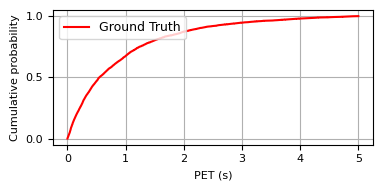

The conflict type, the main vehicle Bicycle, the subvehicle  Car. the total number is 9674


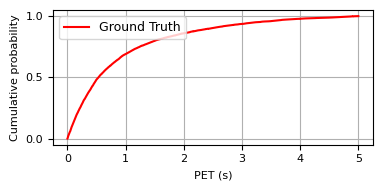

The conflict type, the main vehicle Bicycle, the subvehicle  Van. the total number is 803


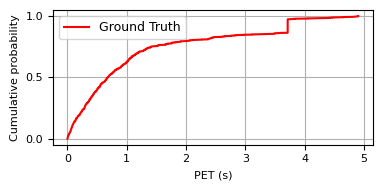

The conflict type, the main vehicle Bicycle, the subvehicle  Motorcycle. the total number is 11126


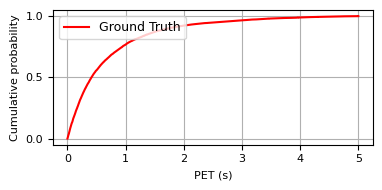

The conflict type, the main vehicle Bicycle, the subvehicle  Bus. the total number is 418


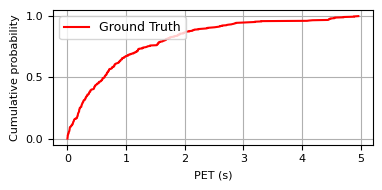

The conflict type, the main vehicle Bicycle, the subvehicle  Light Truck. the total number is 240


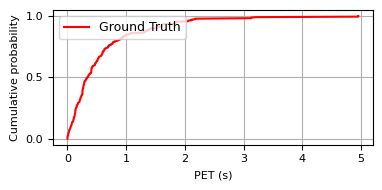

The conflict type, the main vehicle Bicycle, the subvehicle  Tuk-Tuk. the total number is 90


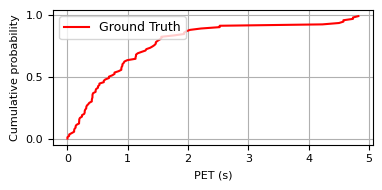

The conflict type, the main vehicle Car, the subvehicle  Bicycle. the total number is 9083


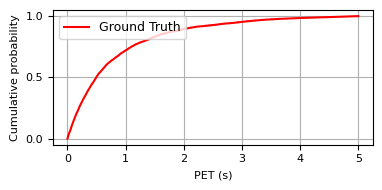

The conflict type, the main vehicle Car, the subvehicle  Car. the total number is 41082


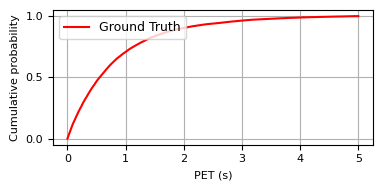

The conflict type, the main vehicle Car, the subvehicle  Van. the total number is 2114


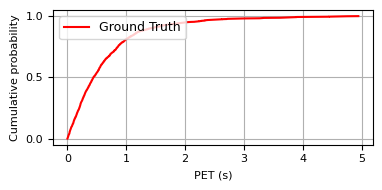

The conflict type, the main vehicle Car, the subvehicle  Motorcycle. the total number is 15051


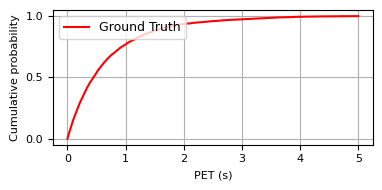

The conflict type, the main vehicle Car, the subvehicle  Bus. the total number is 1627


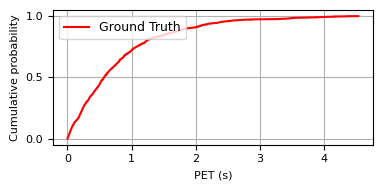

The conflict type, the main vehicle Car, the subvehicle  Light Truck. the total number is 840


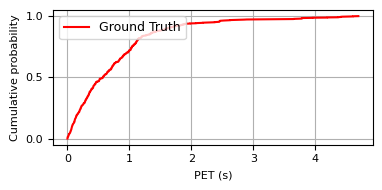

The conflict type, the main vehicle Car, the subvehicle  Tuk-Tuk. the total number is 328


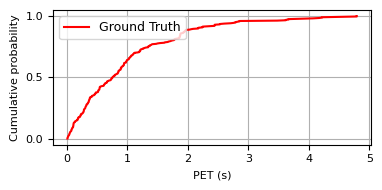

The conflict type, the main vehicle Van, the subvehicle  Bicycle. the total number is 786


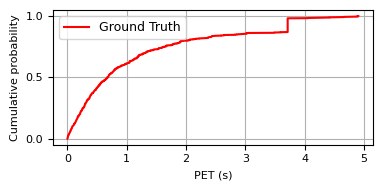

The conflict type, the main vehicle Van, the subvehicle  Car. the total number is 2122


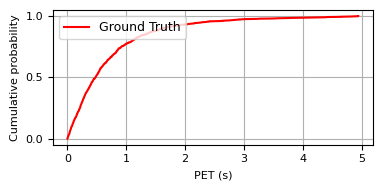

The conflict type, the main vehicle Van, the subvehicle  Van. the total number is 67


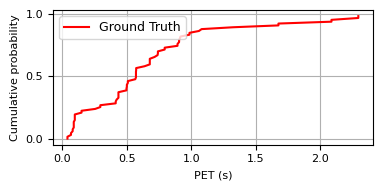

The conflict type, the main vehicle Van, the subvehicle  Motorcycle. the total number is 670


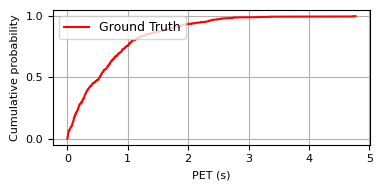

The conflict type, the main vehicle Van, the subvehicle  Bus. the total number is 72


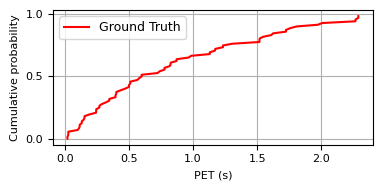

The conflict type, the main vehicle Van, the subvehicle  Light Truck. the total number is 33


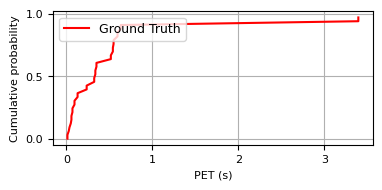

The conflict type, the main vehicle Van, the subvehicle  Tuk-Tuk. the total number is 13


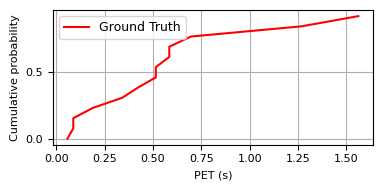

The conflict type, the main vehicle Motorcycle, the subvehicle  Bicycle. the total number is 9284


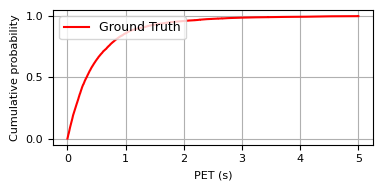

The conflict type, the main vehicle Motorcycle, the subvehicle  Car. the total number is 13377


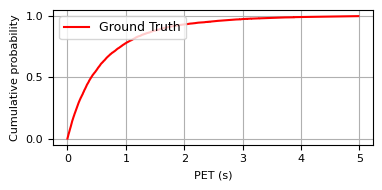

The conflict type, the main vehicle Motorcycle, the subvehicle  Van. the total number is 788


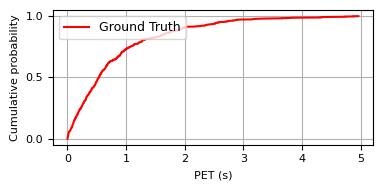

The conflict type, the main vehicle Motorcycle, the subvehicle  Motorcycle. the total number is 21971


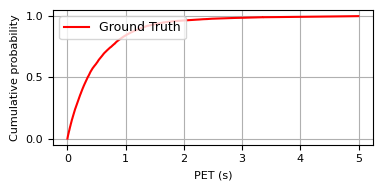

The conflict type, the main vehicle Motorcycle, the subvehicle  Bus. the total number is 959


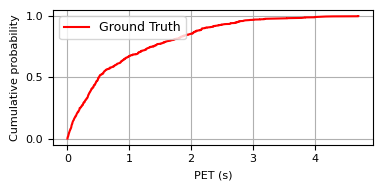

The conflict type, the main vehicle Motorcycle, the subvehicle  Light Truck. the total number is 269


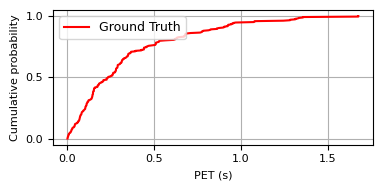

The conflict type, the main vehicle Motorcycle, the subvehicle  Tuk-Tuk. the total number is 35


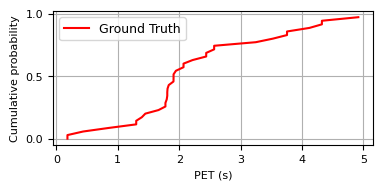

The conflict type, the main vehicle Bus, the subvehicle  Bicycle. the total number is 428


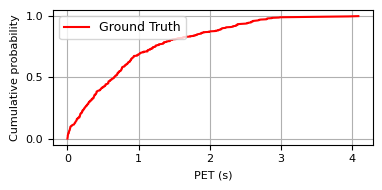

The conflict type, the main vehicle Bus, the subvehicle  Car. the total number is 1956


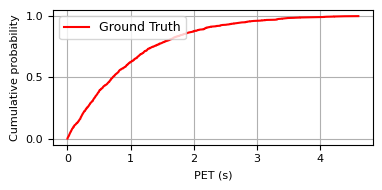

The conflict type, the main vehicle Bus, the subvehicle  Van. the total number is 81


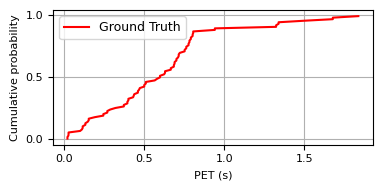

The conflict type, the main vehicle Bus, the subvehicle  Motorcycle. the total number is 937


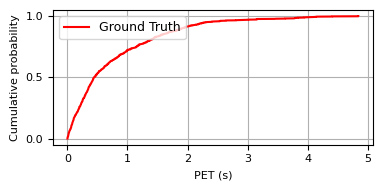

The conflict type, the main vehicle Bus, the subvehicle  Bus. the total number is 168


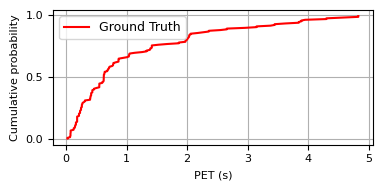

The conflict type, the main vehicle Bus, the subvehicle  Light Truck. the total number is 3


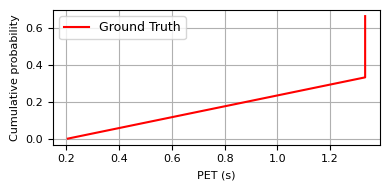

The conflict type, the main vehicle Bus, the subvehicle  Tuk-Tuk. the total number is 4


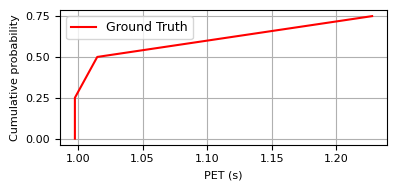

The conflict type, the main vehicle Light Truck, the subvehicle  Bicycle. the total number is 287


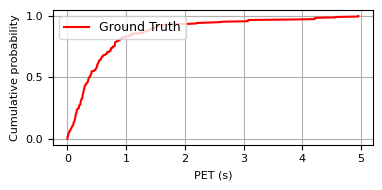

The conflict type, the main vehicle Light Truck, the subvehicle  Car. the total number is 857


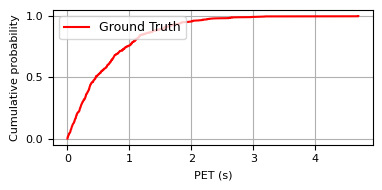

The conflict type, the main vehicle Light Truck, the subvehicle  Van. the total number is 66


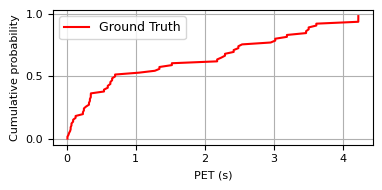

The conflict type, the main vehicle Light Truck, the subvehicle  Motorcycle. the total number is 400


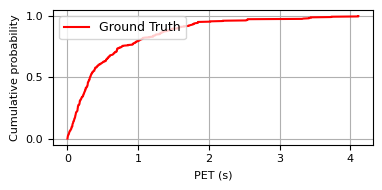

The conflict type, the main vehicle Light Truck, the subvehicle  Bus. the total number is 10


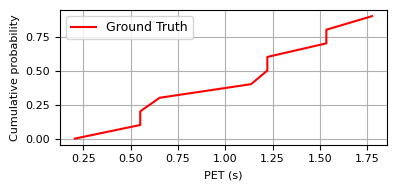

The conflict type, the main vehicle Light Truck, the subvehicle  Light Truck. the total number is 19


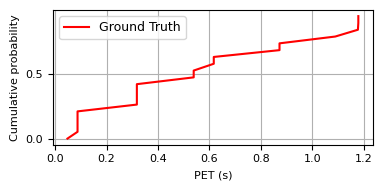

The conflict type, the main vehicle Light Truck, the subvehicle  Tuk-Tuk. the total number is 0


ValueError: max() arg is an empty sequence

In [13]:
# defining the libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ks_2samp
%matplotlib inline

data_original =pet_df[pet_df['PET']<=5]

# classification of the conflict 
M_veh_type = data_original['m_vehicle_type'].unique()
for m_veh_type in M_veh_type:
    M_veh_pet = data_original[data_original['m_vehicle_type']==m_veh_type]
    for sub_veh_type in M_veh_type:
        M_veh_pet_sub = M_veh_pet[M_veh_pet['sub_vehicle_type'] ==sub_veh_type]
        data = M_veh_pet_sub['PET']
        print('The conflict type, the main vehicle'+str(m_veh_type)+', the subvehicle '+str(sub_veh_type)+'. the total number is '+str(len(data)))
        N = data.shape[0]
        Max_value = max(data)
        Min_pet = min(data)
        x = np.sort(data)
        y = np.arange(N) / float(N)
        fig = plt.figure(figsize=(4,2))   
        plt.xlabel('PET (s)',fontsize=8)
        plt.xticks(fontsize=8,rotation=0)
        plt.yticks(fontsize=8)
        plt.ylabel('Cumulative probability',fontsize=8)
        plt.plot(x, y,color='red',label='Ground Truth')
        plt.legend(loc="upper left",fontsize=9)   #设置图例字体大小
        plt.tight_layout()
        plt.grid()
        plt.show()

<!--  --> 首先，识别危险冲突事件。

The conflict type, the main vehicle Bicycle, the subvehicle  Bicycle. the total number is 8397


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


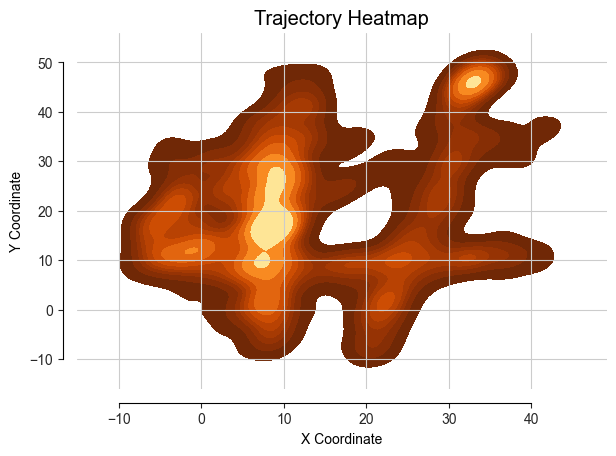

The conflict type, the main vehicle Bicycle, the subvehicle  Car. the total number is 6486


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


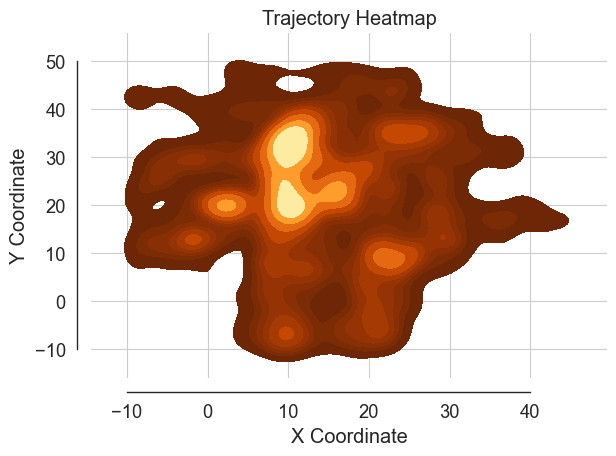

The conflict type, the main vehicle Bicycle, the subvehicle  Van. the total number is 551


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


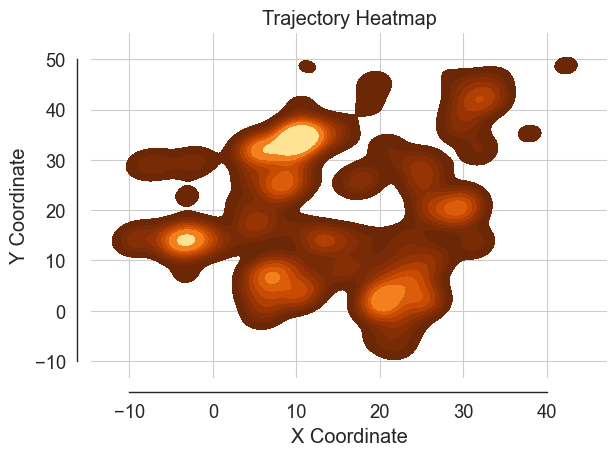

The conflict type, the main vehicle Bicycle, the subvehicle  Motorcycle. the total number is 7954


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


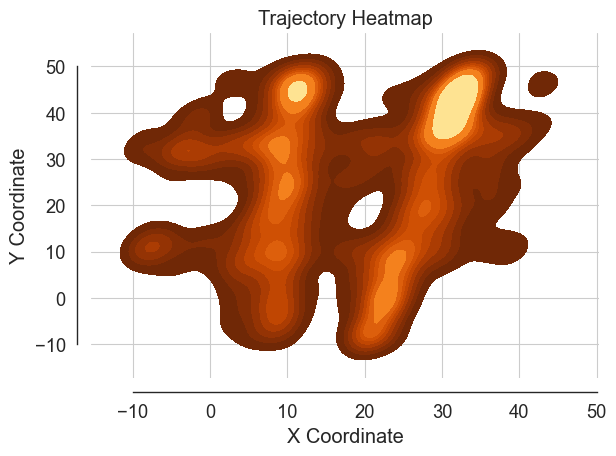

The conflict type, the main vehicle Bicycle, the subvehicle  Bus. the total number is 168


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


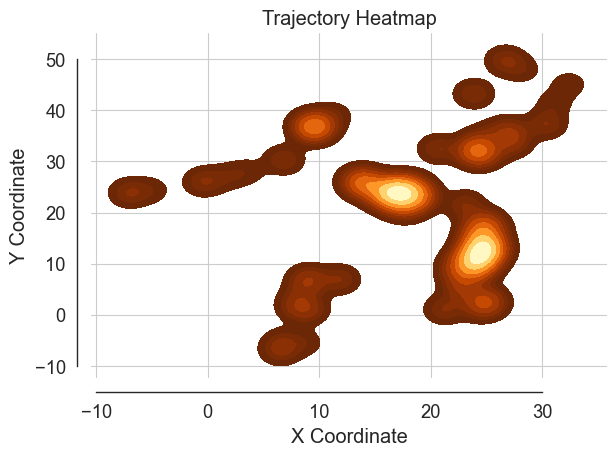

The conflict type, the main vehicle Bicycle, the subvehicle  Light Truck. the total number is 110


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


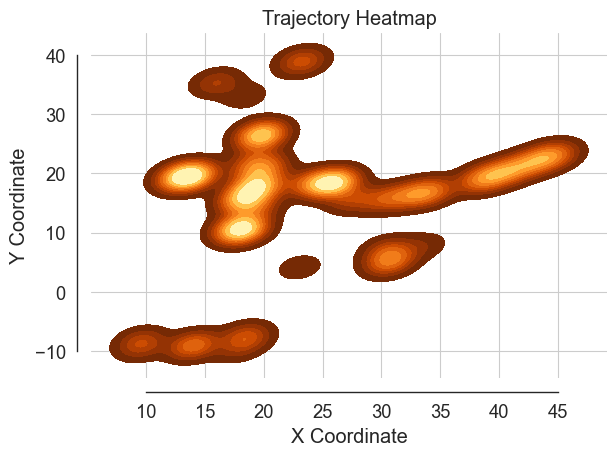

The conflict type, the main vehicle Bicycle, the subvehicle  Tuk-Tuk. the total number is 82


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


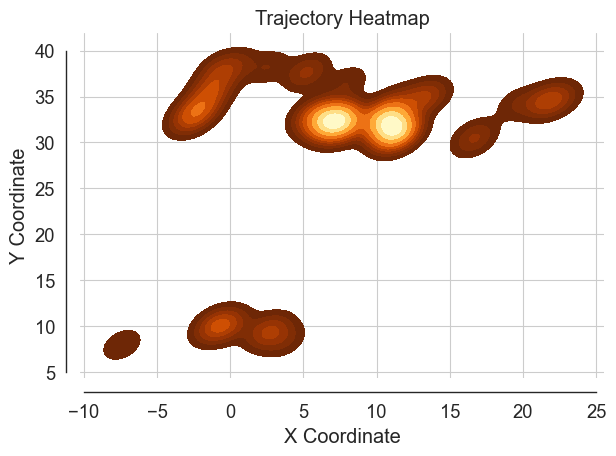

The conflict type, the main vehicle Car, the subvehicle  Bicycle. the total number is 5563


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


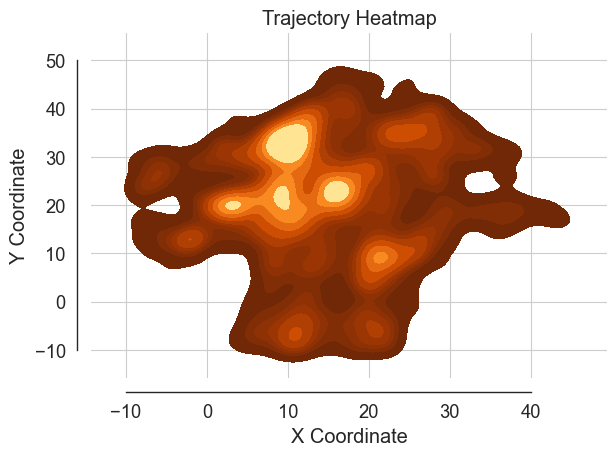

The conflict type, the main vehicle Car, the subvehicle  Car. the total number is 25886


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


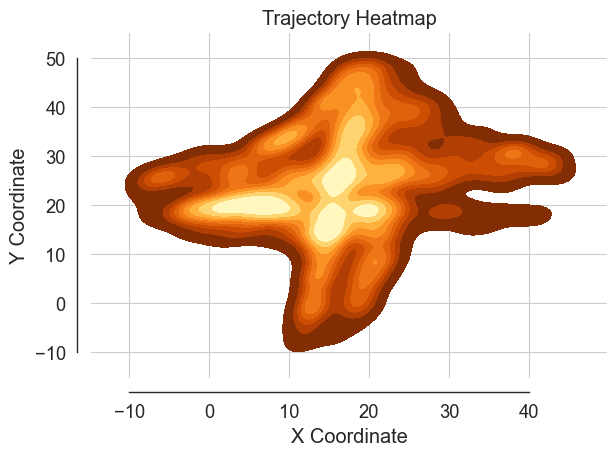

The conflict type, the main vehicle Car, the subvehicle  Van. the total number is 1309


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


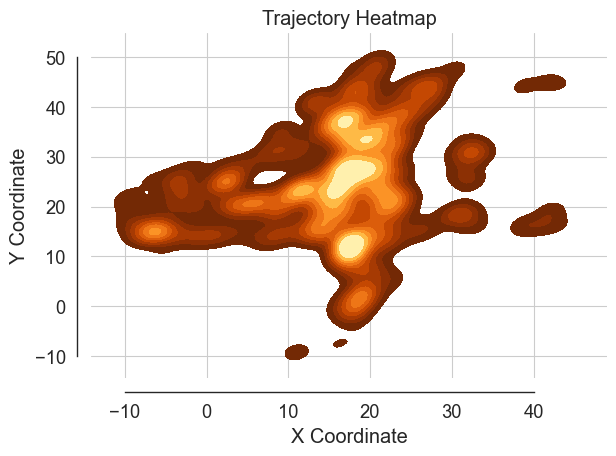

The conflict type, the main vehicle Car, the subvehicle  Motorcycle. the total number is 8375


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


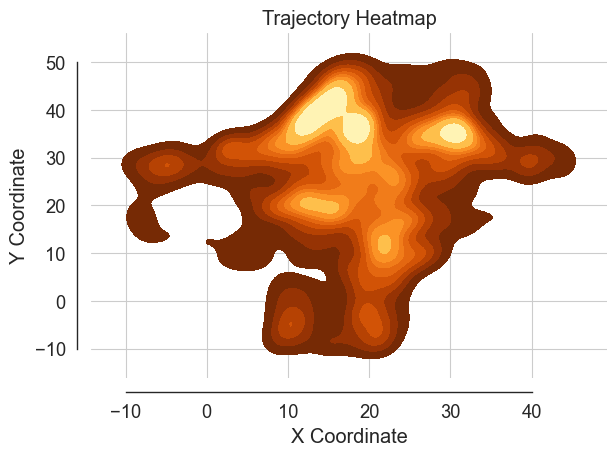

The conflict type, the main vehicle Car, the subvehicle  Bus. the total number is 724


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


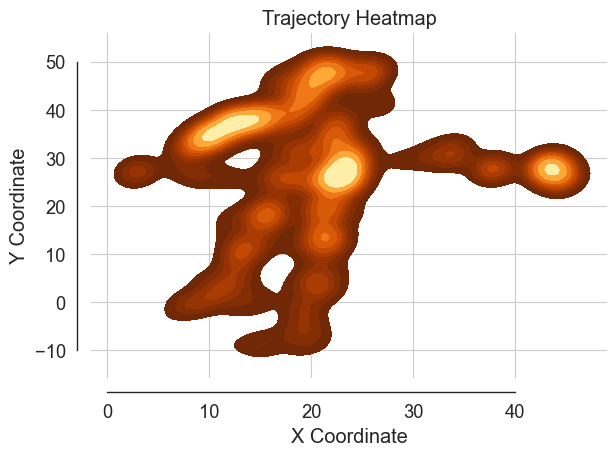

The conflict type, the main vehicle Car, the subvehicle  Light Truck. the total number is 349


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


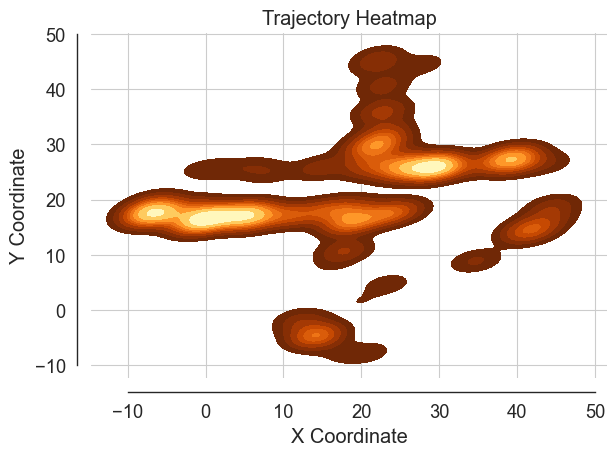

The conflict type, the main vehicle Car, the subvehicle  Tuk-Tuk. the total number is 264


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


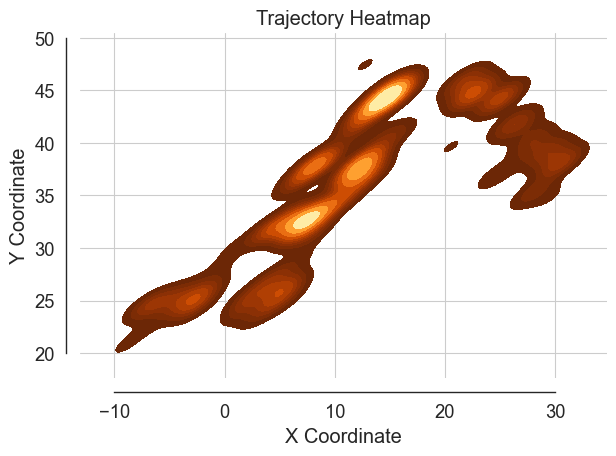

The conflict type, the main vehicle Van, the subvehicle  Bicycle. the total number is 503


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


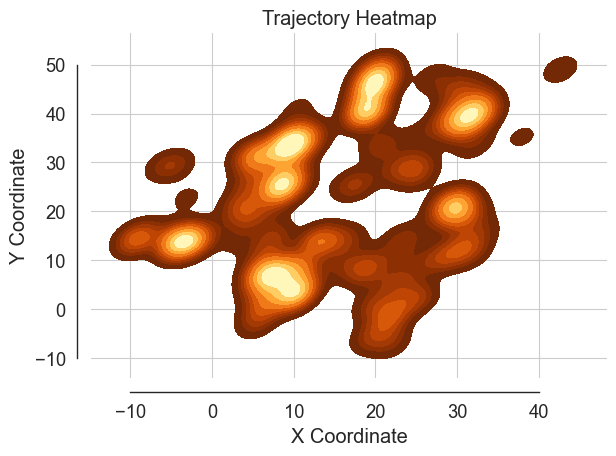

The conflict type, the main vehicle Van, the subvehicle  Car. the total number is 1481


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


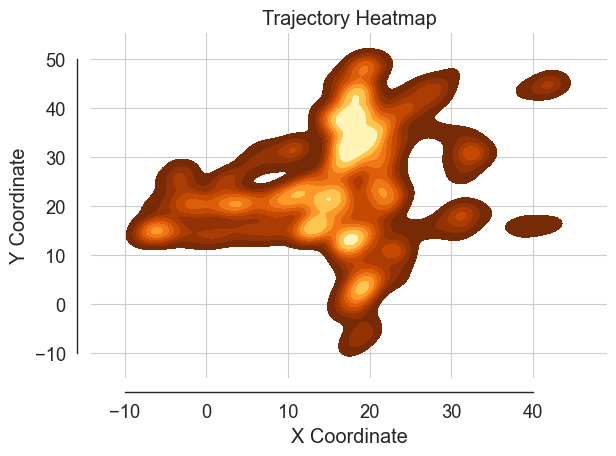

The conflict type, the main vehicle Van, the subvehicle  Van. the total number is 23


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


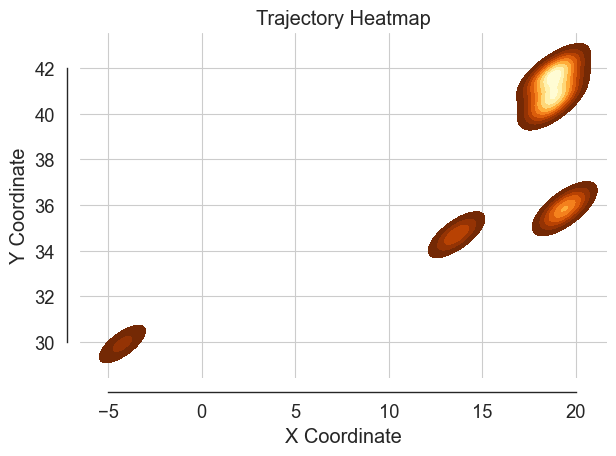

The conflict type, the main vehicle Van, the subvehicle  Motorcycle. the total number is 503


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


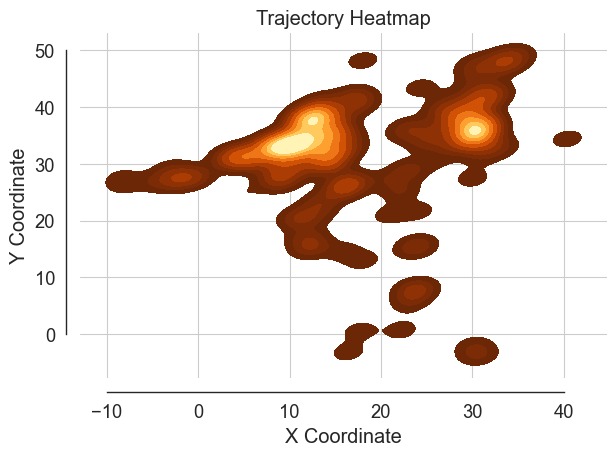

The conflict type, the main vehicle Van, the subvehicle  Bus. the total number is 26


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


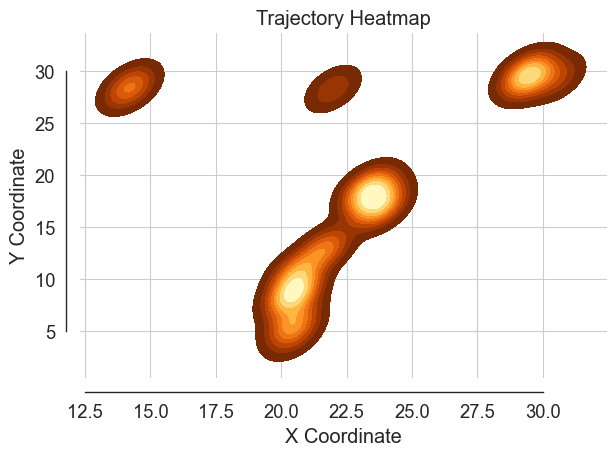

The conflict type, the main vehicle Van, the subvehicle  Light Truck. the total number is 21


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


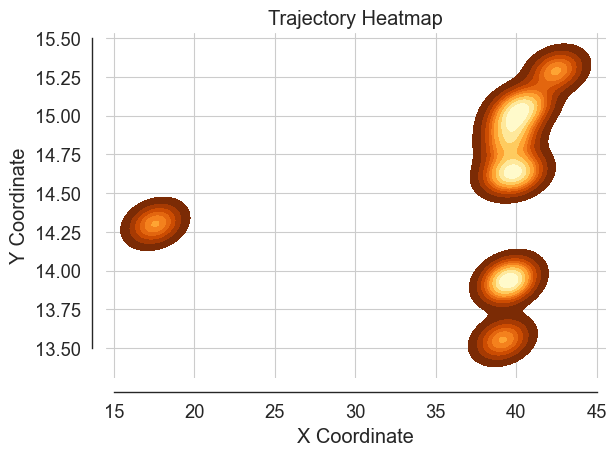

The conflict type, the main vehicle Van, the subvehicle  Tuk-Tuk. the total number is 0


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


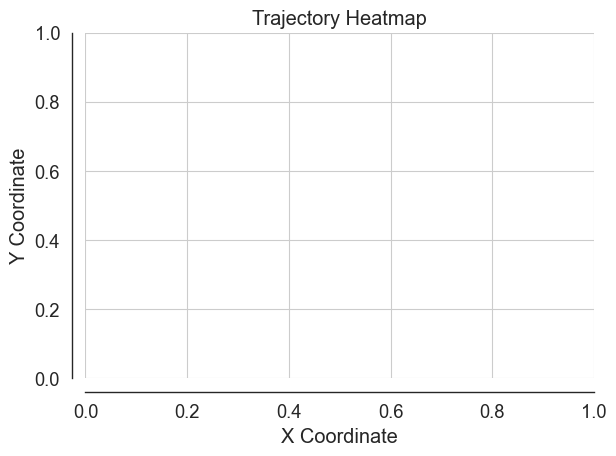

The conflict type, the main vehicle Motorcycle, the subvehicle  Bicycle. the total number is 6429


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


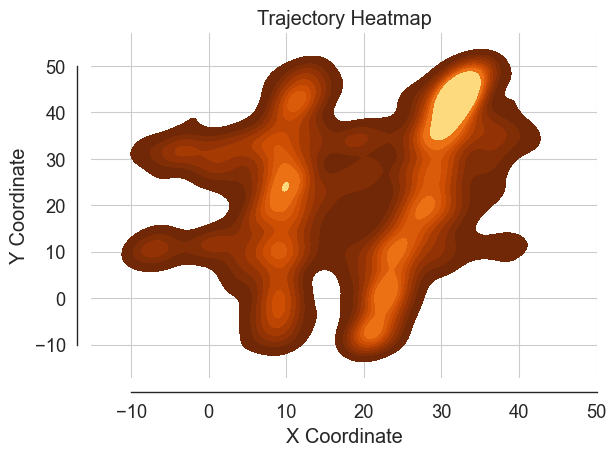

The conflict type, the main vehicle Motorcycle, the subvehicle  Car. the total number is 7666


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


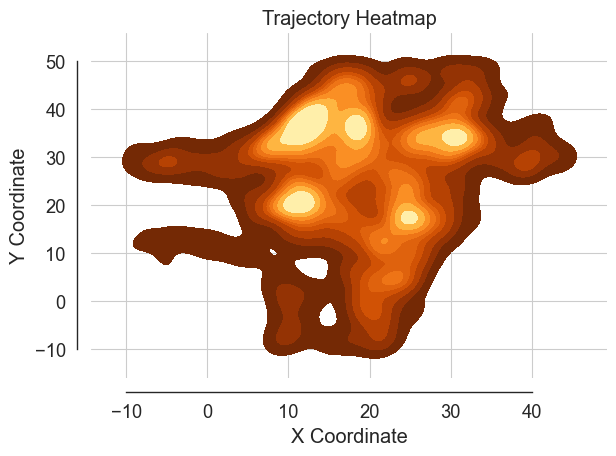

The conflict type, the main vehicle Motorcycle, the subvehicle  Van. the total number is 601


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


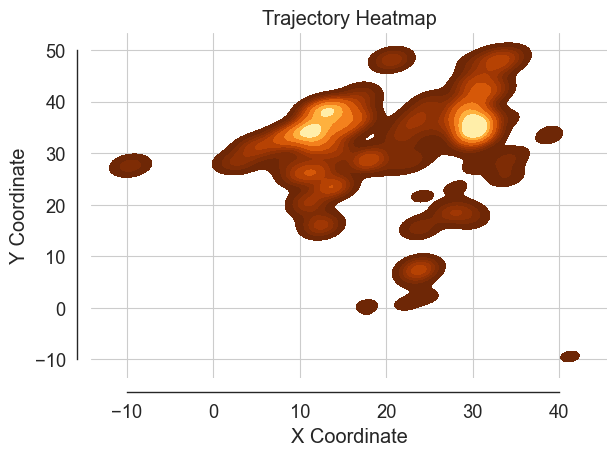

The conflict type, the main vehicle Motorcycle, the subvehicle  Motorcycle. the total number is 15331


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


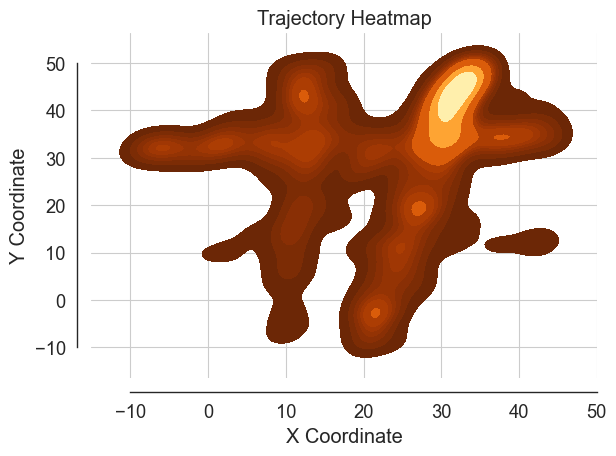

The conflict type, the main vehicle Motorcycle, the subvehicle  Bus. the total number is 566


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


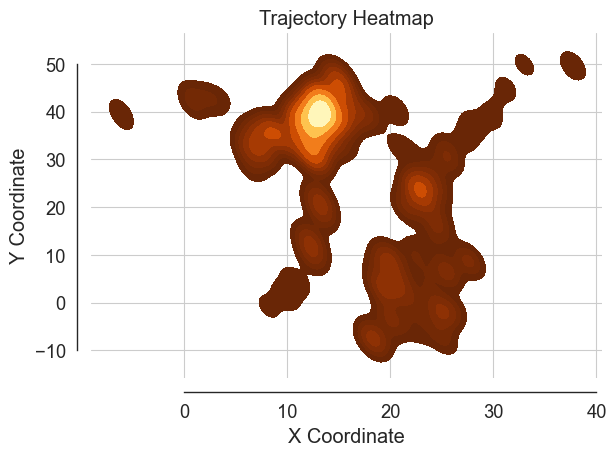

The conflict type, the main vehicle Motorcycle, the subvehicle  Light Truck. the total number is 53


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


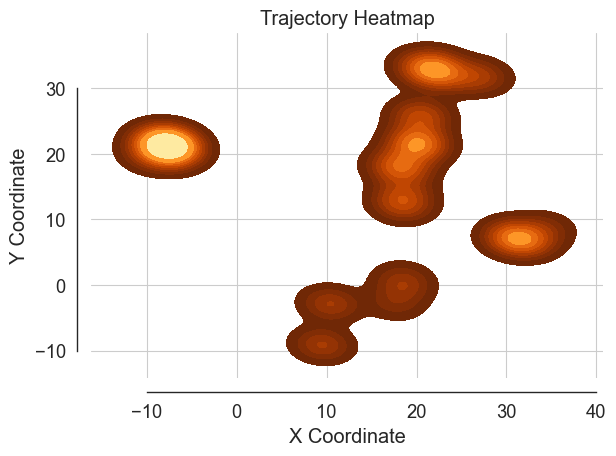

The conflict type, the main vehicle Motorcycle, the subvehicle  Tuk-Tuk. the total number is 47


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


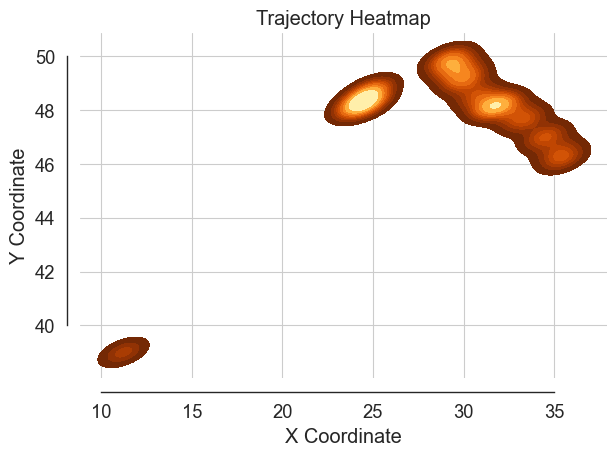

The conflict type, the main vehicle Bus, the subvehicle  Bicycle. the total number is 186


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


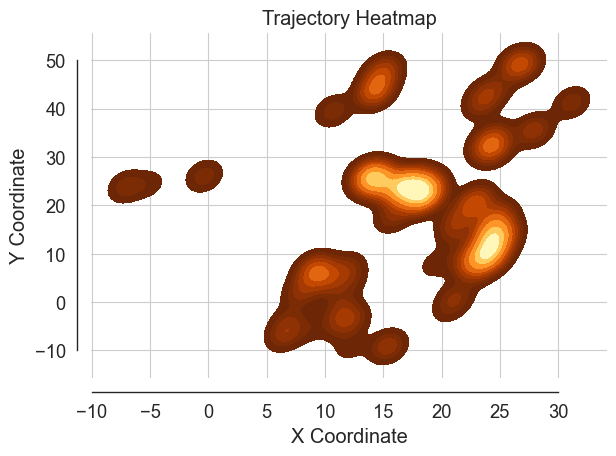

The conflict type, the main vehicle Bus, the subvehicle  Car. the total number is 1048


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


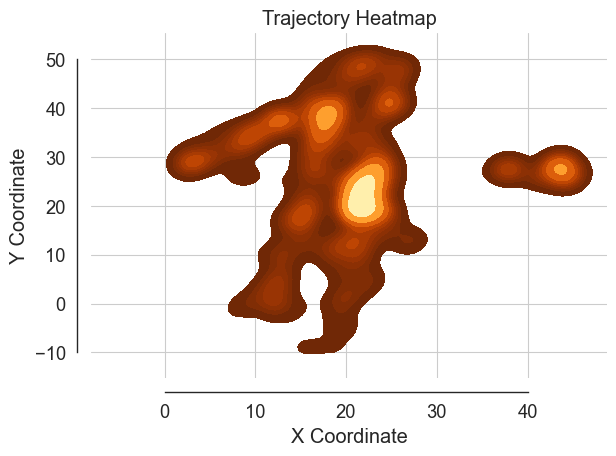

The conflict type, the main vehicle Bus, the subvehicle  Van. the total number is 48


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


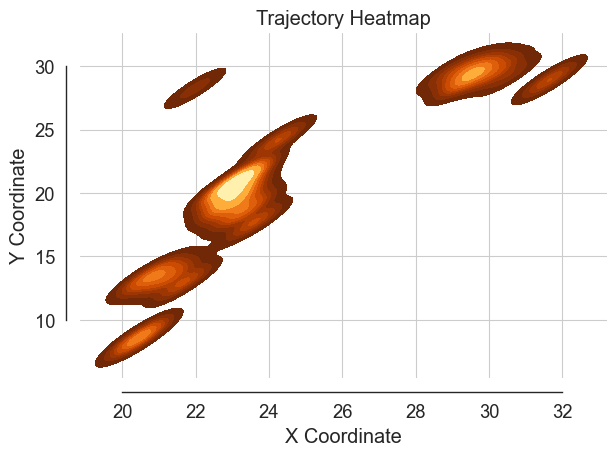

The conflict type, the main vehicle Bus, the subvehicle  Motorcycle. the total number is 479


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


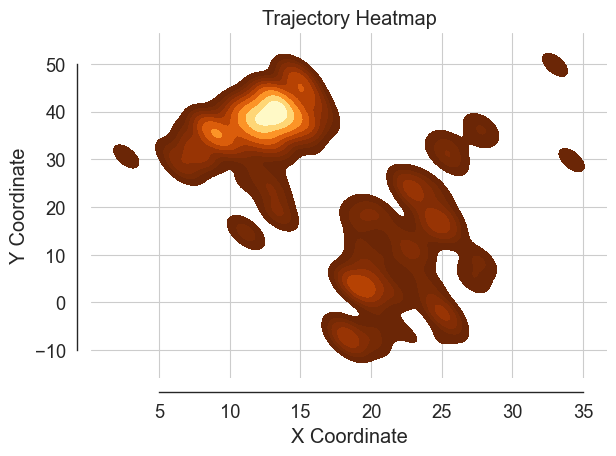

The conflict type, the main vehicle Bus, the subvehicle  Bus. the total number is 149


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


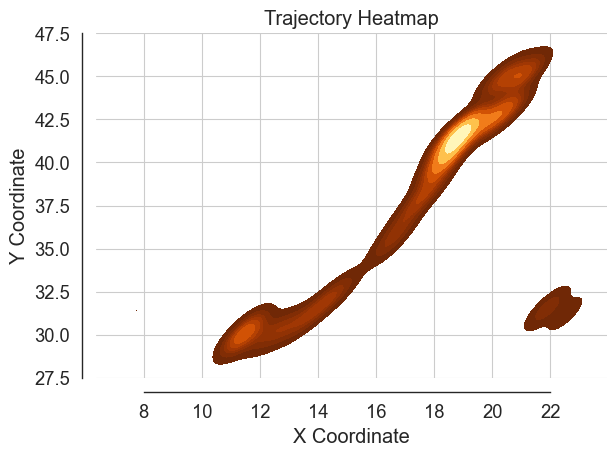

The conflict type, the main vehicle Bus, the subvehicle  Light Truck. the total number is 2


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


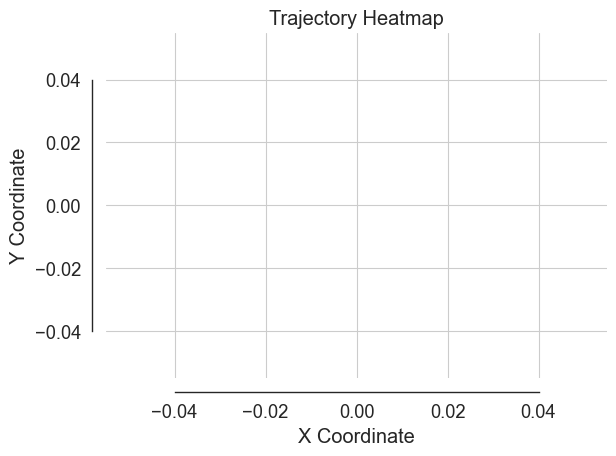

The conflict type, the main vehicle Bus, the subvehicle  Tuk-Tuk. the total number is 4


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


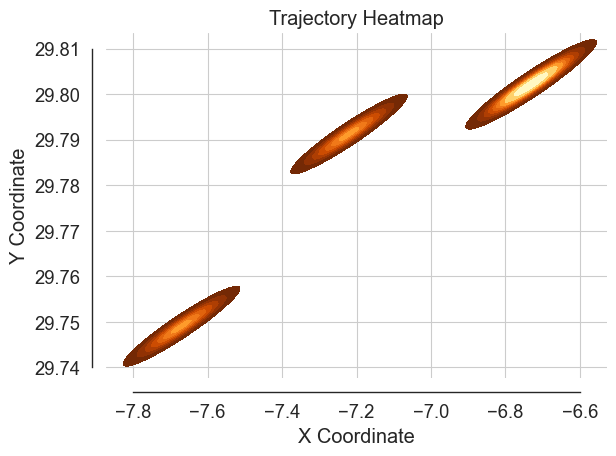

The conflict type, the main vehicle Light Truck, the subvehicle  Bicycle. the total number is 182


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


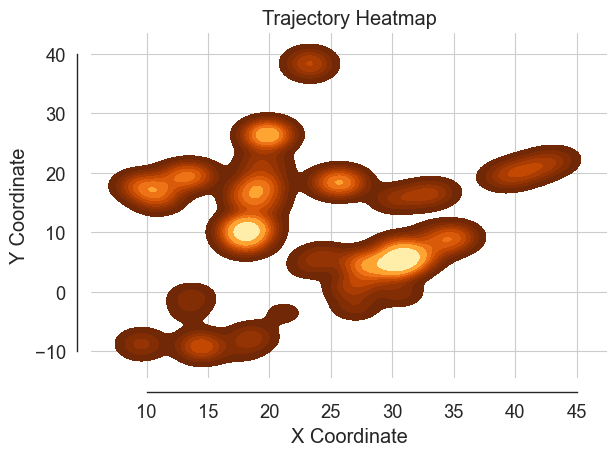

The conflict type, the main vehicle Light Truck, the subvehicle  Car. the total number is 365


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


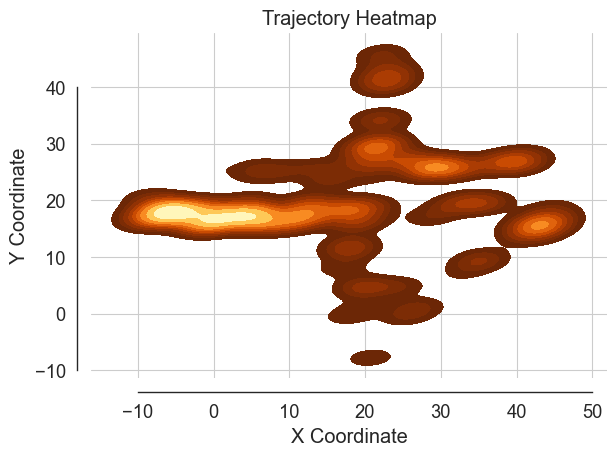

The conflict type, the main vehicle Light Truck, the subvehicle  Van. the total number is 52


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


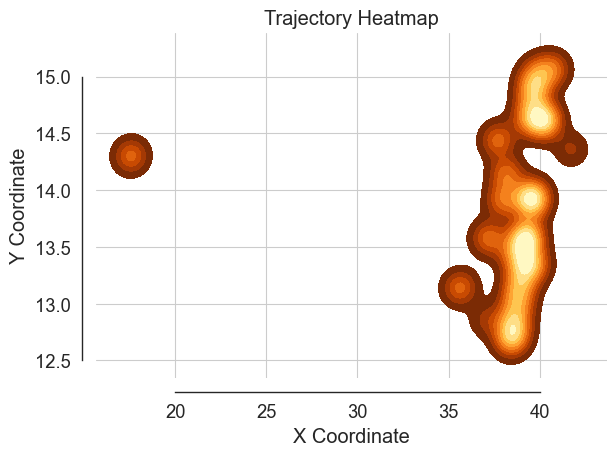

The conflict type, the main vehicle Light Truck, the subvehicle  Motorcycle. the total number is 111


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


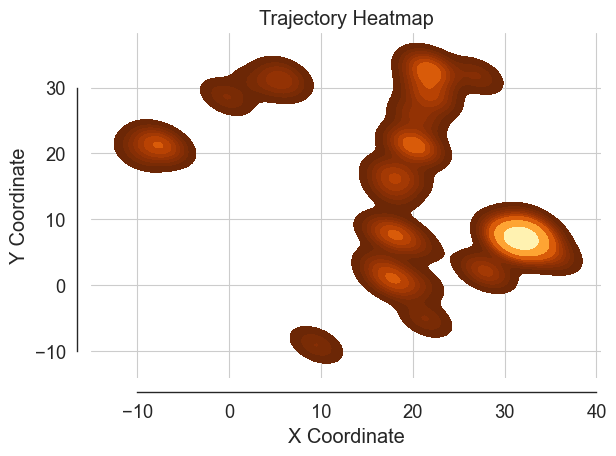

The conflict type, the main vehicle Light Truck, the subvehicle  Bus. the total number is 0


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


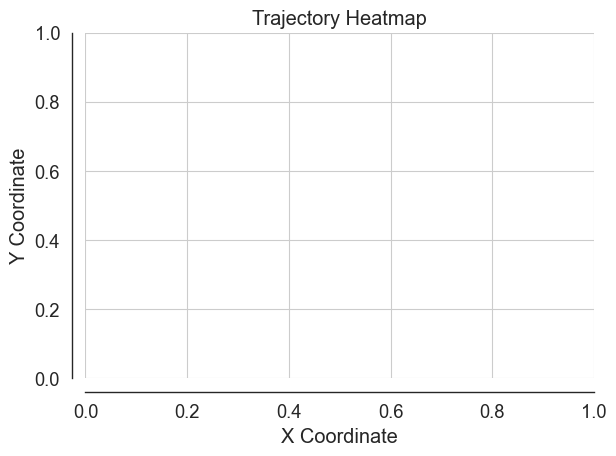

The conflict type, the main vehicle Light Truck, the subvehicle  Light Truck. the total number is 19


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


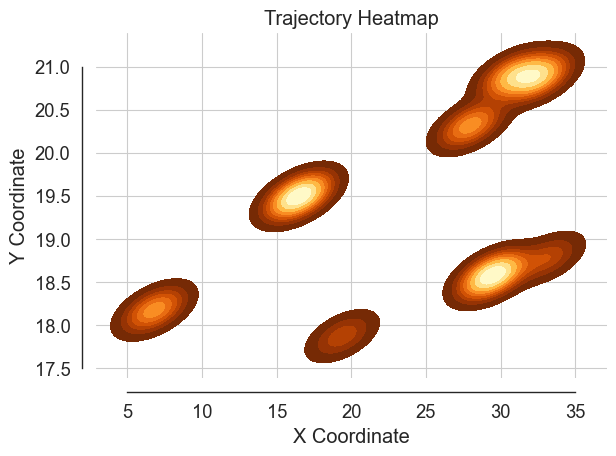

The conflict type, the main vehicle Light Truck, the subvehicle  Tuk-Tuk. the total number is 0


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


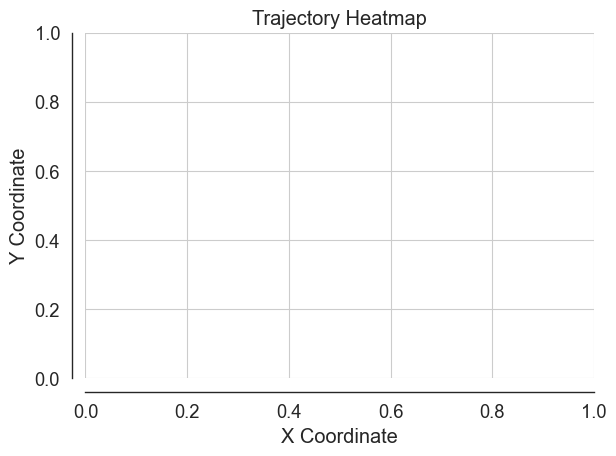

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Bicycle. the total number is 61


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


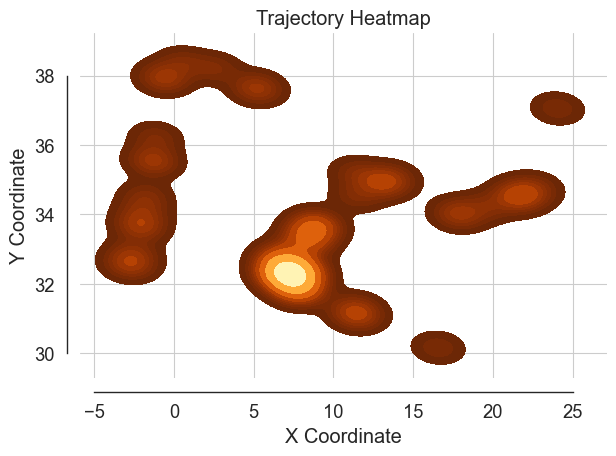

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Car. the total number is 240


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


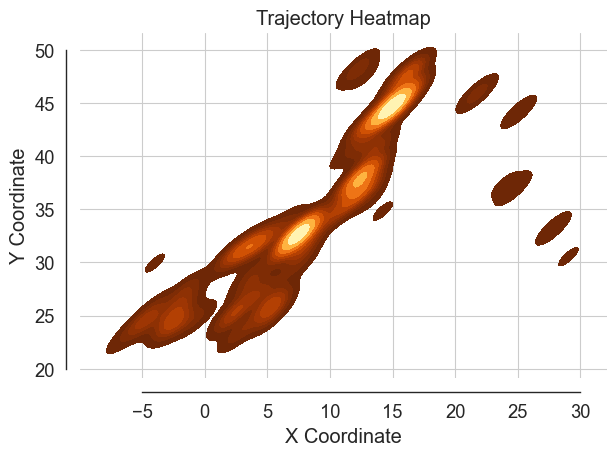

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Van. the total number is 0


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


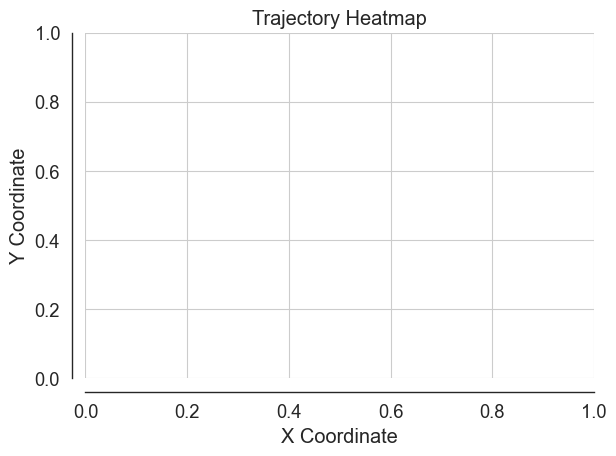

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Motorcycle. the total number is 9


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


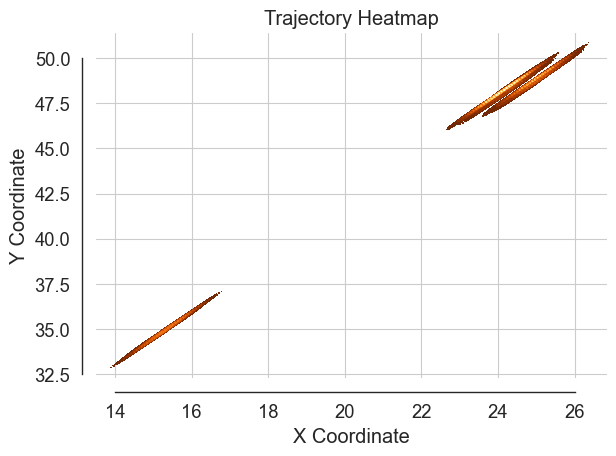

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Bus. the total number is 0


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


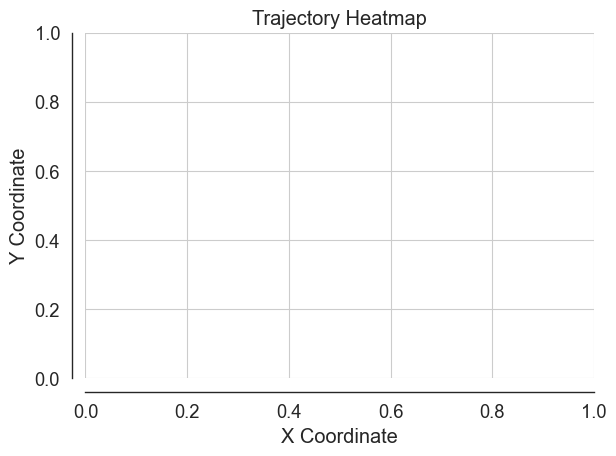

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Light Truck. the total number is 0


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


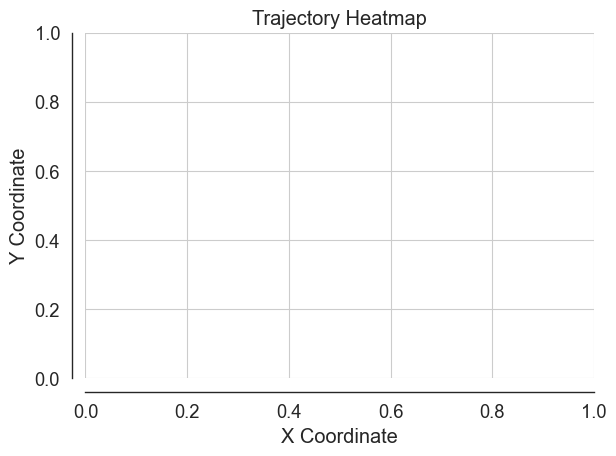

The conflict type, the main vehicle Tuk-Tuk, the subvehicle  Tuk-Tuk. the total number is 133


D:\Research-tools\python\installfile\Anaconda\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


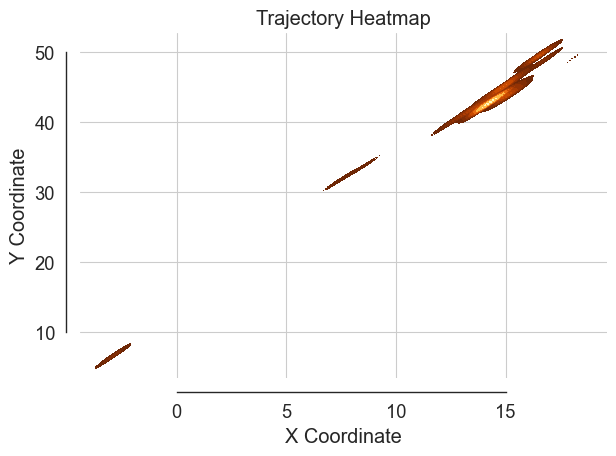

In [11]:
# defining the libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ks_2samp
%matplotlib inline

data_original =pet_df[pet_df['PET']<=10]

# classification of the conflict 
M_veh_type = data_original['m_vehicle_type'].unique()
for m_veh_type in M_veh_type:
    M_veh_pet = data_original[data_original['m_vehicle_type']==m_veh_type]
    for sub_veh_type in M_veh_type:
        M_veh_pet_sub = M_veh_pet[M_veh_pet['sub_vehicle_type'] ==sub_veh_type]
        data = M_veh_pet_sub[['cross_point_x','cross_point_y']]
        data = pd.DataFrame(data)
        # limited the edges Original_data = Original_data.drop(Original_data[Original_data.world_x <= -10].index)
        data = data.drop(data[data.cross_point_x <= -10].index)
        data = data.drop(data[data.cross_point_x >= 45].index)
        data = data.drop(data[data.cross_point_y <= -10].index)
        data = data.drop(data[data.cross_point_y >= 50].index)
        
        print('The conflict type, the main vehicle'+str(m_veh_type)+', the subvehicle '+str(sub_veh_type)+'. the total number is '+str(len(data)))
        # Create a 2D density plot using Seaborn's kdeplot function
        sns.kdeplot(data=data, x='cross_point_x', y='cross_point_y', cmap='YlOrBr_r', shade=True, bw=.15)
        # Customize the plot
        sns.set_style('white')
        sns.despine(offset=10, trim=True)
        sns.set_context('paper', font_scale=1.5)
        # Add labels and title
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title('Trajectory Heatmap of conflict between '+str(m_veh_type)+' and '+ str(sub_veh_type))
        plt.tight_layout()
        plt.grid()
        plt.show()

 **Extract the conflict event from the trajectory conflict data!**
   First, classificatory /'klæsifikeitəri/ the conflict kinds based on the vehicle type;
   Second, classificatory the conflict based on the motion direction;
   Then,  